# Project Plan

- [x] Acquire Avax Price Data
-   [x] Acquire historical data from [CoinMarketCap](https://coinmarketcap.com/) or similar resource
-   [ ] Acquire live data 
- [x] Use Kats to build predictive forecast models for comparison.


In [13]:

import json
import pandas as pd
import datetime
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib
import kats
#import warnings
from kats.models.sarima import SARIMAParams
import statsmodels.api as sm
#warnings.simplefilter(action='ignore')
pd.plotting.register_matplotlib_converters()
plt.rc('lines', color ='red')
pd.options.plotting.backend = "plotly"

In [14]:

today =  datetime.datetime.today().strftime('%Y-%m-%d')


In [15]:
avax_data = pd.read_csv('avalanche_2020-9-26_2022-2-26.csv').iloc[::-1]
avax_data.head()
avax_data['Average Daily Price'] = avax_data[['Open', 'Close']].mean(axis=1)
avax_daily_ave = avax_data[['Date','Average Daily Price']]
avax_daily_ave['Date'] = pd.to_datetime(avax_daily_ave['Date'])
avax_daily_ave.set_index('Date', inplace=True)
avax_daily_ave.head()
avax_daily_ave.tail()
avax_daily_ave



/tmp/ipykernel_6669/736495959.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Average Daily Price
Date,
2020-09-26,4.622540
2020-09-27,4.576908
2020-09-28,4.427049
2020-09-29,4.169829
2020-09-30,4.230119
...,...
2022-02-22,72.352580
2022-02-23,74.136868
2022-02-24,74.888994


In [16]:
def plot_close_prices():
    """
    Plot the closing prices of AVAX in plotly.
    """
    fig = px.line(avax_daily_ave, y='Average Daily Price', title='AVAX Average Daily Prices')
    fig.update_traces(line_color='#e84142')
    fig.show()
plot_close_prices()

In [17]:
def decomp():
    """
    Perform seasonal decomposition on the avax_daily_ave dataframe.
    """
    avax_decomp = sm.tsa.seasonal_decompose(avax_daily_ave['Average Daily Price'], model='additive')
    fig = px.line(avax_decomp.observed, title='AVAX Average Daily Prices')
    fig.update_traces(line_color='#e84142')
    fig.show()
    fig = px.line(avax_decomp.trend, title='AVAX Average Daily Prices Trend')
    fig.update_traces(line_color='#e84142')
    fig.show()
    fig = px.line(avax_decomp.seasonal, title='AVAX Average Daily Prices Seasonal')
    fig.update_traces(line_color='#e84142')
    fig.show()
    fig = px.line(avax_decomp.resid, title='Seasonal Residuals')
    fig.update_traces(line_color='#e84142')
    fig.show()

decomp()

# Train/Test Split

In [18]:
def train_test_split():
    """
    Split the avax_daily_ave dataframe into training and test sets.
    """
    train = avax_daily_ave[:int(len(avax_daily_ave)*0.8)]
    test = avax_daily_ave[int(len(avax_daily_ave)*0.8):]
    return train, test
train, test = train_test_split()


# Time-series Model


/home/austin/anaconda3/envs/avax_env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



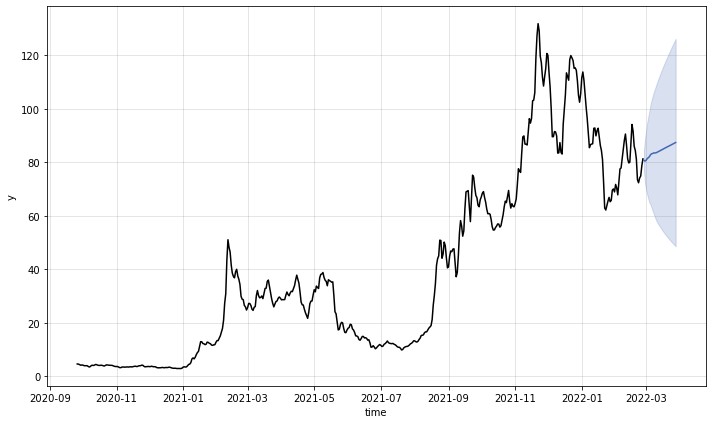

,time,Average Daily Price
0,2020-09-26,4.622540
1,2020-09-27,4.576908
2,2020-09-28,4.427049
3,2020-09-29,4.169829
4,2020-09-30,4.230119
...,...,...
514,2022-02-22,72.352580
515,2022-02-23,74.136868
516,2022-02-24,74.888994
517,2022-02-25,78.686014


In [19]:
if 'time' not in avax_daily_ave.columns:
    avax_daily_ave.index.rename("time", inplace=True)
    avax_daily_ave.reset_index(inplace=True)



def build_baseline_model():
    """
    Baseline ARIMA model for avax_daily_ave using kats.models.sarima.
    """
    params = SARIMAParams(
    p = 2, 
    d=1, 
    q=1, 
    trend = 'ct', 
    seasonal_order=(1,0,1,12)
    )
    
    ts = kats.consts.TimeSeriesData(avax_daily_ave)
    model = kats.models.sarima.SARIMAModel(data = ts, params = params)
    model.fit()
    fcst = model.predict(steps=30)
    #model.summary()
    model.plot()
    plt.show()
    return fcst
b = build_baseline_model()
avax_daily_ave

# History + Forecast (Baseline) 

In [25]:
def next_30_days():
    """
    Create a series of dates for the next 30 days after the last date in the original data.
    """
    last_date = avax_daily_ave['time'].iloc[-1]
    next_30_days = pd.date_range(last_date, periods=30, freq='D')
    return next_30_days
#print(avax_daily_ave['time'])
b.rename(columns={'fcst':'Average Daily Price'}, inplace=True)
bounds = b[['time','fcst_lower','fcst_upper']]
baseline_forecast = b.drop(columns=['fcst_lower', 'fcst_upper'], axis=1)
hist_forecast = pd.concat([avax_daily_ave, baseline_forecast], axis=0)
#print(hist_forecast)
def plot_hist_bl_forecast():
    """
    Plot the original price data plus the forecasted price data in plotly express.
    """
    #hist_forecastx = hist_forecast.drop(columns=['fcst_lower', 'fcst_upper'], axis=1)
    fig = px.line(hist_forecast, x='time', y='Average Daily Price', title='AVAX Average Daily Price + 30 Day Forecast')
    fig.update_traces(line_color='#e84142')
    fig.add_vline(x=avax_daily_ave['time'].iloc[-1], line_width=2, line_dash='dash')
    fig.add_annotation(x=avax_daily_ave['time'].iloc[-1], y=avax_daily_ave['Average Daily Price'].iloc[-1], text="Start of Forecast", showarrow=True)
    fig.show()
plot_hist_bl_forecast()
#hist_forecast.tail()

# Forecasting Avax Price for the next 30 days (Baseline Model)

# Compare the predicted price with the actual price

# Advanced Experimental Model 